# Installation of Datasets

Datasets must be installed before they can be loaded into memory and used with ML models. The procedure can be manual or fully automatic and needs to be run only once. In this tutorial we will be installing the CWRU bearing dataset, a widely adopted reference in the community of MHM. The same procedure applies also for other datasets. Specific instructions of installation can be found in the document page of each dataset.

In [1]:
# # Disable tf's logging
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

import logging
logging.basicConfig()
logging.getLogger('dpmhm').setLevel(10)

2024-05-02 17:10:59.139362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 17:11:00.052936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import dpmhm
import dpmhm.datasets

## Installing the dataset CWRU
Installing a dataset consists of 2 steps:
1. downloading the original files from appropriate sources
2. building the dataset of [tfrecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format using [`tensorflow-datasets`](https://www.tensorflow.org/datasets/overview). 
 
The building step involves parsing and converting the original dataset, where we followed the principle that all information from the original dataset should be preserved if possible. In particular, each original data file is mapped to an item in the built dataset.

In [3]:
# Define first the location for the tensorflow datasets (including temporary files of download & extraction). 
# On Unix-like systems, the default location is `~/tensorflow_datasets`. 
# This can be changed by setting the environment variable `TFDS_DATA_DIR` or passing the argument in the python 
# methods `tfds.builder()` or `tfds.load()` or via the CLI `tfds build`.

TFDS_DATA_DIR = os.path.expanduser('~/tensorflow_datasets/')

### Method 1: Automatic installation
We use the method `dpmhm.datasets.install()` to automatically install a dataset. This method is a thin wrapper of `tfds.load()`. 

In [4]:
try:
    _ = dpmhm.datasets.install('CWRU', 
                           data_dir=TFDS_DATA_DIR,
    #                            download_dir=,
    #                            extract_dir=,
    #                            manual_dir=,
                              )
except Exception as msg:
    print(msg)

DEBUG:dpmhm.datasets:Downloading data files...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Failed to get url https://sandbox.zenodo.org/records/1183527/files/cwru.zip. HTTP code: 404.


This will install the dataset `cwru` in the place specified by `data_dir`. If `data_dir` is not set the value of the environment variable `TFDS_DATA_DIR` will be used (default to `~/tensorflow_datasets`).

`dpmhm.datasets.install()` will by default save the download into the subfolder `TFDS_DATA_DIR/dpmhm/downloads` and extract the data files into `TFDS_DATA_DIR/dpmhm/extracted`. These folders can be modified by specifying the keyword arguments.

### Method 2: Manual installation
In case that automatic installation cannot be completed, due to e.g. difficulties in downloading the orginal data files, we resort to manual installation by separating the steps of download and build. First download and extract manually all data files via the terminal commands

```sh
$ cd ~/tmp
$ curl URL_OF_DATA_SOURCE -o cwru.zip
$ unzip cwru.zip  # extract all files into the folder `~/tmp/cwru`.
```

Then pass the argument `manual_dir` in `dpmhm.datasets.install()` to build the dataset:

In [ ]:
_ = dpmhm.datasets.install('CWRU', 
                            data_dir=TFDS_DATA_DIR,                           
                            manual_dir=os.path.expanduser('~/tmp/cwru')
                          )

Or equivalently build the dataset with the command [`tfds build`](https://www.tensorflow.org/datasets/cli)
```sh
$ tfds build CWRU --imports dpmhm.datasets.cwru --manual_dir ~/tmp/cwru --data_dir ~/tensorflow_datasets
```
which will read the data files in `~/tmp/cwru` and build the dataset into `~/tensorflow_datasets`. 

### Remove an installed dataset

To remove the installed dataset, simply delete the folder `cwru` contained in the folder `TFDS_DATA_DIR`. To reinstall the dataset, repeat the procedure above and the data files already downloaded & extracted will be automatically reused.

## Load & Visualization

After installation, the dataset is stored locally and can be loaded into memory using `tfds.load()`.

In [6]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name, 
    data_dir=TFDS_DATA_DIR,
    # split=['train[:75%]', 'train[75%:]'],   
    # split=['all'],
    with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


In general the variable `ds_all` may contain multiple fields of split, and `ds_info` contains information about the dataset.
Here the only split of CWRU is 'train'. The built dataset has 161 records which is also the number of files in the original dataset.

In [7]:
ds0.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=161>

Let's take one element from the dataset and show its content:

In [8]:
eles = list(ds0.take(10).as_numpy_iterator())

eles[0]

2024-05-02 17:13:08.767225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'metadata': {'Dataset': b'CWRU',
  'FaultComponent': b'Ball',
  'FaultLocation': b'DriveEnd',
  'FaultSize': 0.014,
  'FileName': b'185.mat',
  'LoadForce': 0,
  'NominalRPM': 1797,
  'RPM': 1796},
 'sampling_rate': 12000,
 'signal': {'BA': array([ 0.00164973,  0.08047478,  0.0341213 , ..., -0.01879086,
         -0.02470576, -0.09411525], dtype=float32),
  'DE': array([-0.46781316,  0.1790035 ,  0.4812953 , ..., -0.33770263,
         -0.16909496,  0.17786647], dtype=float32),
  'FE': array([ 0.09697454,  0.27058363,  0.13642181, ..., -0.02547636,
          0.19168909, -0.04663818], dtype=float32)}}

Plot and play the wavform of different records / channels:

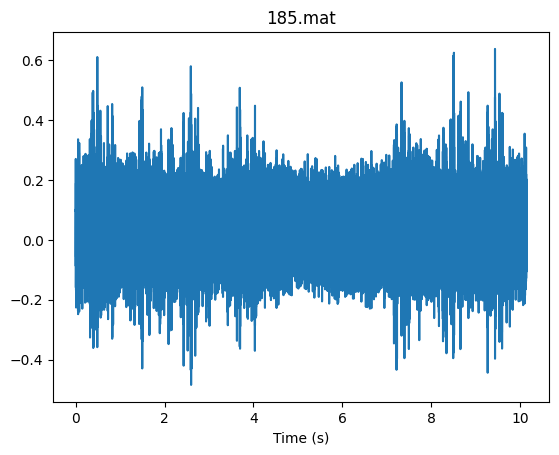

In [9]:
fn = eles[0]['metadata']['FileName'].decode()
sr = eles[0]['sampling_rate']
x = eles[0]['signal']['FE']

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

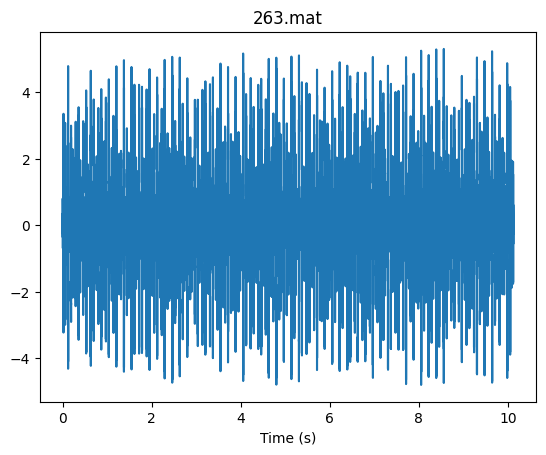

In [10]:
fn = eles[1]['metadata']['FileName'].decode()
sr = eles[1]['sampling_rate']
x = eles[1]['signal']['DE']

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

The element specification of a dataset is given by the property `.element_spec`. CWRU contains 3 channels ['BA', 'DE', 'FE'] and a common sampling rate. The variable `ds_info` contains the meaning of each field.

In [11]:
ds0.element_spec

{'metadata': {'Dataset': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}